# Ensemble Learning through Soft Bagging 

**bagging == Bootstrapping Aggregation** 

$\implies$  hyperparam = {M = #learners, alpha = # relative trainset size}


In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [2]:
np.random.seed(2020)

In [3]:
N_train = 2000
N_test = 50000
d = 1
T = 2

In [4]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [5]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [6]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [7]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07954044595186821

In [8]:
X_test.shape

(50000, 1, 2)

## Compare with Hard voting

In [9]:
from aggregating.models import SoftBagger, SimpleBagger
from aggregating.utils import flatten_X
soft = SoftBagger(2,0.7,GaussianProcessRegressor(kernel,copy_X_train=False))
hard = SimpleBagger(2,0.7,GaussianProcessRegressor(kernel,copy_X_train=False))
soft.fit(flatten_X(X_train),y_train)
hard.fit(flatten_X(X_train),y_train)

fit
(2000, 2)
fit
(2000, 2)


In [10]:
from aggregating.utils import normalized_error_VT
print(normalized_error_VT(y_test, soft.predict(flatten_X(X_test)), V_0))
print(normalized_error_VT(y_test, hard.predict(flatten_X(X_test)), V_0))

 soft predict
(50000, 2)
0.17749598441504108
predict
(50000, 2)
0.21554643110808067


## GridSearch

nB: cannot use Scikit gridsearch as it performs CV and we want to have a different test set of a larger size!

In [11]:
from multiprocessing import  cpu_count,current_process
from multiprocessing.pool import ThreadPool
import functools
import threading

from aggregating.gridsearch import create_logger, evaluate_model
from aggregating.utils import flatten_X

# GRIDSEARCH PARAMS
model = SoftBagger(0,0,GaussianProcessRegressor(kernel,copy_X_train=False))
trials = 4
M_grid = [1,2,3,4]
alpha_grid = [0.5,0.7,0.9,1.0]
results = []

### ACTUAL GRIDSEARCH
pool = ThreadPool(4) #avoid allocation issues
for m in M_grid:
    for alpha in alpha_grid:
        hyperparams= {'M':m, 'train_size_alpha':alpha}
        pool.apply_async(evaluate_model, args=(model,hyperparams,flatten_X(X_train),y_train,1, [1/12,11/12],trials,N_test,MaxCallStochasticModel),callback = create_logger(hyperparams,results))
pool.close()
pool.join()



 {'M': 1, 'train_size_alpha': 0.5} -> thread id = 19836
fit
(2000, 2)
 {'M': 1, 'train_size_alpha': 0.7} -> thread id = 37664
fit
(2000, 2)
 {'M': 1, 'train_size_alpha': 0.9} -> thread id = 25264
fit
(2000, 2)
 {'M': 1, 'train_size_alpha': 1.0} -> thread id = 36456
fit
(2000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.5} , 0 -> 0.21444231103861738
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.7} , 0 -> 0.2913408145527774
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.9} , 0 -> 0.2712055707007414
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 1.0} , 0 -> 0.191701446010262
{'M': 1, 'train_size_alpha': 0.5} , 1 -> 0.21443570811514623
 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.7} , 1 -> 0.28794117201729535
 soft predict
(50000, 2)
{'M': 1, 'train_size_alpha': 0.9} , 1 -> 0.2528797760437774{'M': 1, 'train_size_alpha': 0.5} , 2 -> 0.205683

 soft predict
(50000, 2)
{'M': 3, 'train_size_alpha': 1.0} , 2 -> 0.12920934114524163
 soft predict
(50000, 2)
{'M': 4, 'train_size_alpha': 0.7} , 0 -> 0.23624557606597169
 soft predict
(50000, 2)
{'M': 3, 'train_size_alpha': 1.0} , 3 -> 0.14297784611980835
{'M': 3, 'train_size_alpha': 1.0} -> [0.17378772671745915, 0.17311681096314924, 0.12920934114524163, 0.14297784611980835]
logger {'M': 3, 'train_size_alpha': 1.0}, -> [0.17378772671745915, 0.17311681096314924, 0.12920934114524163, 0.14297784611980835]
 soft predict
(50000, 2)
{'M': 4, 'train_size_alpha': 0.7} , 1 -> 0.25683077767513984
 soft predict
(50000, 2)
{'M': 4, 'train_size_alpha': 0.7} , 2 -> 0.2223326141517127{'M': 4, 'train_size_alpha': 0.9} , 0 -> 0.22716429639125094

 soft predict
(50000, 2)
 soft predict
(50000, 2)
{'M': 4, 'train_size_alpha': 0.7} , 3 -> 0.27688864167524924
{'M': 4, 'train_size_alpha': 0.7} -> [0.23624557606597169, 0.25683077767513984, 0.2223326141517127, 0.27688864167524924]
logger {'M': 4, 'train_siz

In [12]:
converted_results = np.ones((len(M_grid),len(alpha_grid),trials))*(-1)
for item in results:
    print(item)
    converted_results[M_grid.index(item[0]),alpha_grid.index(item[1])] = item[2]

print(converted_results.shape)
print(converted_results)

[1, 0.5, [0.21444231103861738, 0.21443570811514623, 0.20568338494493957, 0.18748275609177525]]
[1, 0.7, [0.2913408145527774, 0.28794117201729535, 0.29280886413139173, 0.27844648190479343]]
[1, 0.9, [0.2712055707007414, 0.2528797760437774, 0.27111041703970623, 0.2541520577942254]]
[1, 1.0, [0.191701446010262, 0.19848144803053686, 0.22071126231379326, 0.19148702920780536]]
[2, 0.5, [0.20647103702335437, 0.21262290032789516, 0.21909544023198993, 0.20136175813319232]]
[2, 0.7, [0.17737937119723746, 0.19228226703921214, 0.15973494327048454, 0.15288325582906795]]
[2, 0.9, [0.1883035311970486, 0.20657681913147208, 0.2323409498069565, 0.19627432788957674]]
[3, 0.5, [0.19335853967363867, 0.22327802878464367, 0.1996358338251176, 0.18920371993027743]]
[2, 1.0, [0.12384542017469018, 0.16053570974248102, 0.1376668041326575, 0.15926943422038767]]
[3, 0.7, [0.21815300832120207, 0.2158305796506924, 0.2191150611215789, 0.21889670483843227]]
[3, 0.9, [0.18796744602527454, 0.19611437146769314, 0.17836127

In [13]:
masked_results= np.ma.masked_where(converted_results <= 0.0,converted_results) # some runs have been aborted every now and then -> filter them out
means = masked_results.mean(axis=2)
sigmas = masked_results.std(axis=2)
means.shape

(4, 4)

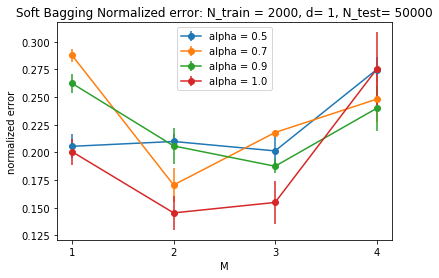

In [17]:
for i in range(len(alpha_grid)):
    plt.errorbar(np.array(M_grid),means[:,i],sigmas[:,i],marker ='o',label = f"alpha = {alpha_grid[i]}")
plt.title(f"Soft Bagging Normalized error: N_train = {N_train}, d= {d}, N_test= {N_test}")
plt.xlabel("M")
plt.xticks(M_grid)
plt.ylabel("normalized error")
plt.legend()
plt.show()

## Store results

In [18]:
res_dict = {'N_train': N_train, 'N_test': N_test,'mgrid': M_grid, 'alpha_grid': alpha_grid, 'errors': converted_results.tolist()}

In [19]:
import json
import datetime
with open(f'soft_bagging_w_replacement_{str(datetime.date.today())}.json', 'w') as fp:
    json.dump(res_dict, fp)